## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
path_to_folder = 'CW_Folder_PG' 
dir_path = os.path.join('drive', 'My Drive', path_to_folder)

## Import Libraries

In [84]:
import sys
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from sklearn import svm, metrics

%matplotlib inline

## Unzip dataset folder

In [5]:
## === Code adapted from Lab_07 of INM460 === ##

# Identify path to zipped dataset
zip_path = os.path.join(dir_path, 'CW_Dataset', 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

## Import data for train and test set

In [6]:
def import_data(label_name):
    """Load images and labels for train and test set from selected directories"""
    images = []
    labels = []
    
    img_files = [img for img in sorted(os.listdir(label_name)) if img.endswith('.jpg')] # image files sorted in ascending order
    label_file = os.path.join('labels', 'list_label_'+label_name+'.txt') # label file corresponding to train or test
    for img in img_files:
      images.append(io.imread(os.path.join(label_name, img)))
    df = pd.read_csv(label_file, header=None, delimiter=r"\s+")
    df = df.sort_values(0) # sort (in ascending order) label dataframe by first column which are img names
    labels = df.iloc[:, 1].tolist()
    return images, labels

## EDA

In [7]:
X_train, y_train = import_data('train')
X_test, y_test = import_data('test')

In [8]:
print(f'X_train shape: {np.shape(X_train)} \nX_test shape: {np.shape(X_test)}')

X_train shape: (12271, 100, 100, 3) 
X_test shape: (3068, 100, 100, 3)


In [9]:
print(f'y_train shape: {np.shape(y_train)} \ny_test shape: {np.shape(y_test)}')

y_train shape: (12271,) 
y_test shape: (3068,)


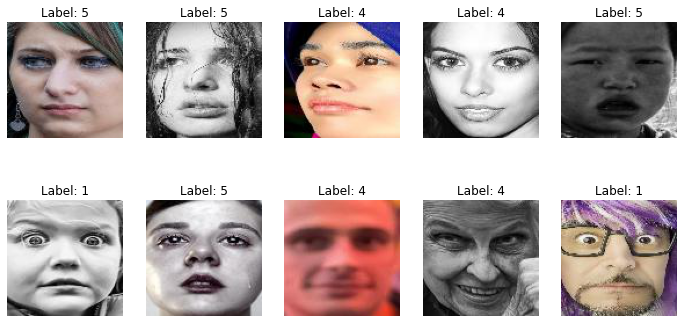

In [10]:
## === Code adapted from Lab_06 of INM460 === ##
X_train_img = np.array(X_train)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_train_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_train[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

In [11]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test) 

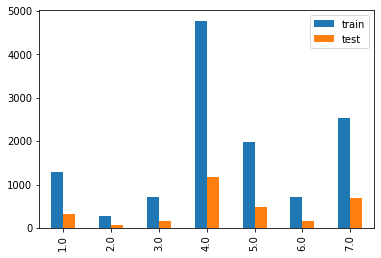

In [12]:
df = pd.DataFrame({'train': pd.Series(y_train_counter), 
                   'test': pd.Series(y_test_counter) })

ax = df.plot.bar()
labs = [round(float(t.get_text()), 1) for t in ax.axes.get_xmajorticklabels()]
ax.set_xticklabels(labs);

## Apply SMOTE to train set
Since we have an imbalanced dataset we will apply SMOTE method for oversampling (only to train set)

In [13]:
sm = SMOTE(random_state=42) # seed for reproducibility 
# flatten the image to be able to pass to sklearn (since sklearn only accepts 2d array)
num_rows=len(X_train)
X_train_reshaped = np.array(X_train).reshape(num_rows,-1)
print(f'Flattened X_train shape: {X_train_reshaped.shape}, y_train shape: {np.shape(y_train)}')

Flattened X_train shape: (12271, 30000), y_train shape: (12271,)


In [14]:
# apply smote on flattened image
X_train_sm, y_train = sm.fit_resample(X_train_reshaped, y_train)
print(f'Smoted X_train shape: {X_train_sm.shape}, y_train shape: {np.shape(y_train)}')

Smoted X_train shape: (33404, 30000), y_train shape: (33404,)


In [15]:
# reshape the flattened image back to its [num_samples, height, width, channel] dimensions
X_train = X_train_sm.reshape(-1,100,100, 3)
print(f'New X_train shape: {X_train.shape}, y_train shape: {np.shape(y_train)}')

New X_train shape: (33404, 100, 100, 3), y_train shape: (33404,)


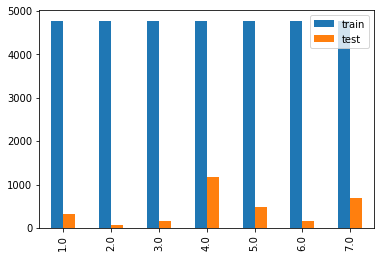

In [16]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)
df = pd.DataFrame({'train': pd.Series(y_train_counter), 
                   'test': pd.Series(y_test_counter) })

ax = df.plot.bar()
labs = [round(float(t.get_text()), 1) for t in ax.axes.get_xmajorticklabels()]
ax.set_xticklabels(labs);

## HOG features

In [70]:
## === Code adapted from Lab_06 of INM460 === ##

HOG_images = []
HOG_des = []

for image in X_train: 
  des, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, multichannel=True)
  HOG_images.append(hog_image)
  HOG_des.append(des)

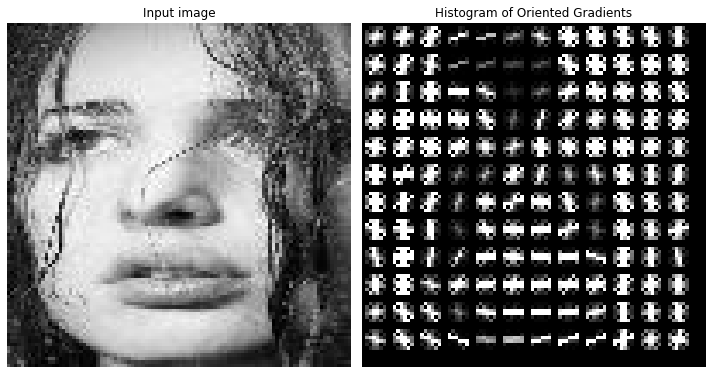

In [72]:
## === Code adapted from Lab_06 of INM460 === ##
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax[0].axis('off')
ax[0].imshow(X_train[1])
ax[0].set_title('Input image')

# Rescale histogram for better display
HOG_image_rescaled = exposure.rescale_intensity(HOG_images[1], in_range=(0, 10))

ax[1].axis('off')
ax[1].imshow(HOG_image_rescaled, cmap='gray')
ax[1].set_title('Histogram of Oriented Gradients')
fig.tight_layout()
plt.show()

In [77]:
## === Code adapted from Lab_07 of INM460 === ##

# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf', random_state=42) # random state for reproducibility
classifier.fit(HOG_des, y_train)

SVC(random_state=42)

In [78]:
## === Code adapted from Lab_06 of INM460 === ##

HOG_images_test = []
HOG_des_test = []

for image in X_test: 
  des, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, multichannel=True)
  HOG_images_test.append(hog_image)
  HOG_des_test.append(des)

In [79]:
y_pred = classifier.predict(HOG_des_test).tolist()

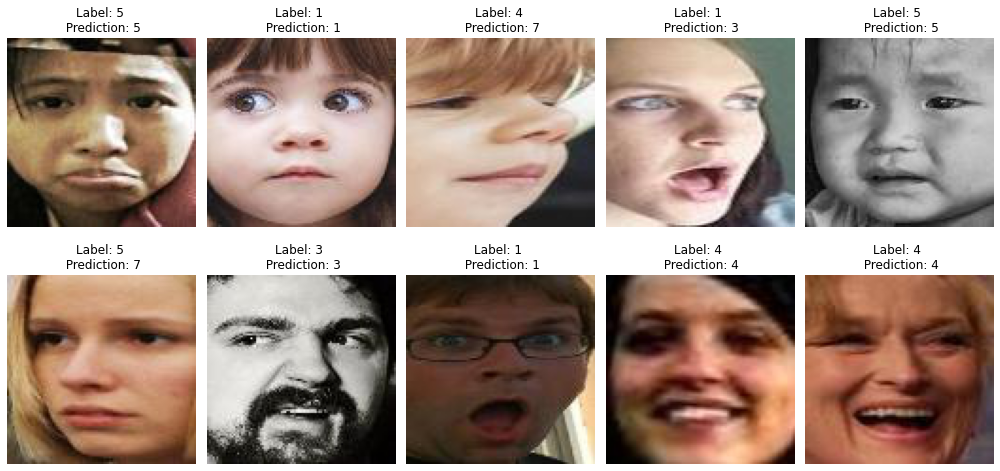

In [80]:
## === Code adapted from Lab_07 of INM460 === ##

fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [81]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC(random_state=42):
                    precision    recall  f1-score   support

           1       0.68      0.62      0.65       329
           2       0.64      0.39      0.49        74
           3       0.45      0.28      0.35       160
           4       0.83      0.89      0.86      1185
           5       0.64      0.58      0.61       478
           6       0.60      0.56      0.58       162
           7       0.67      0.75      0.71       680

    accuracy                           0.72      3068
   macro avg       0.64      0.58      0.60      3068
weighted avg       0.71      0.72      0.71      3068




In [82]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y_pred))

Accuracy on unknown data is 0.720013037809648


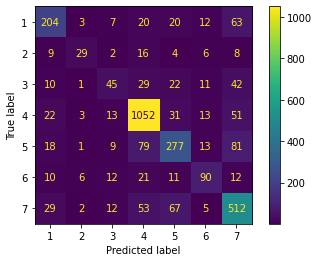

In [83]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
# Performing CV to tune parameters for best SVM fit 
from sklearn.model_selection import cross_val_score, GridSearchCV
params_grid = [{'kernel': ['rbf'], 
                'gamma': [1e-3, 1e-4],
                'C': [1, 10, 100, 1000],
                'decision_function_shape': ['ovr', 'ovo']
                }]

svm_model = GridSearchCV(svm.SVC(), params_grid, cv=5)
svm_model.fit(hist_array, y_train_list)